In [1]:
from datetime import datetime, timedelta

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter

import fly_analysis as fa
from fly_analysis.trajectory import detect_saccades

In [2]:
def create_saccade_heatmap(df, grid_size=50):
    """
    Create a heatmap of saccade locations in the circular arena.

    Args:
    df (pd.DataFrame): DataFrame containing fly trajectory data.
    grid_size (int): Number of grid cells along each dimension.

    Returns:
    np.array: 2D array representing the saccade heatmap.
    """
    # Define arena parameters
    arena_radius = 0.25  # 25cm radius
    x_range = y_range = [-arena_radius, arena_radius]

    # Create grid
    x_edges = np.linspace(x_range[0], x_range[1], grid_size + 1)
    y_edges = np.linspace(y_range[0], y_range[1], grid_size + 1)
    heatmap = np.zeros((grid_size, grid_size))

    # Process each trajectory
    for obj_id, group in df.groupby("obj_id"):
        if len(group) >= 300:
            if (
                (-0.2 <= group.x.median() <= 0.2)
                & (-0.2 <= group.y.median() <= 0.2)
                & (0.1 <= group.z.median() <= 0.3)
            ):
                if (
                    (group.x.max() - group.x.min() > 0.1)
                    & (group.y.max() - group.y.min() > 0.1)
                    & (group.z.max() - group.z.min() > 0.1)
                ):
                    for section in fa.trajectory.extract_flying_sections(
                        group, min_flight_duration=150
                    ):
                        # Detect saccades
                        saccade_indices, _ = detect_saccades(section, height=1000)

                        # Get saccade locations
                        saccade_locations = group.iloc[saccade_indices][["x", "y"]]

                        # Bin saccade locations
                        h, _, _ = np.histogram2d(
                            saccade_locations["x"],
                            saccade_locations["y"],
                            bins=[x_edges, y_edges],
                        )
                        heatmap += h

    return heatmap


def plot_saccade_heatmap(heatmap, arena_radius=0.25, sigma=0.5):
    """
    Plot the saccade heatmap.

    Args:
    heatmap (np.array): 2D array representing the saccade heatmap.
    arena_radius (float): Radius of the arena in meters.
    """
    if sigma is not None:
        heatmap = gaussian_filter(heatmap, sigma=sigma)

    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot heatmap
    im = ax.imshow(
        heatmap.T,
        origin="lower",
        extent=[-arena_radius, arena_radius, -arena_radius, arena_radius],
        cmap="hot",
        interpolation="nearest",
    )

    # Add colorbar
    plt.colorbar(im, ax=ax, label="Number of Saccades")

    # Plot arena boundary
    circle = plt.Circle((0, 0), arena_radius, fill=False, color="blue")
    ax.add_artist(circle)

    # Set labels and title
    ax.set_xlabel("X position (m)")
    ax.set_ylabel("Y position (m)")
    ax.set_title("Saccade Heatmap")

    # Set aspect ratio to equal for circular plot
    ax.set_aspect("equal")

    plt.tight_layout()
    plt.show()


In [3]:
def analyze_fly_activity(df):
    # Convert UNIX timestamp to datetime
    df["datetime"] = pd.to_datetime(df["timestamp"], unit="s")

    # Extract hour of day
    df["hour"] = df["datetime"].dt.floor("H")

    # Filter trajectories longer than 300 frames
    long_objs = fa.filtering.filter_by_duration(df, threshold=3)
    print(f"Found {len(long_objs)} trajectories longer than 300 frames")
    median_objds = fa.filtering.filter_by_median_position(df)
    print(f"Found {len(median_objds)} trajectories with median position")
    good_objs = fa.helpers.find_intersection(long_objs, median_objds)
    print(f"Found {len(good_objs)} trajectories with both filters")

    df_filtered = df[df["obj_id"].isin(good_objs)]

    # Group by hour and obj_id
    grouped = df_filtered.groupby(["hour", "obj_id"])

    # Calculate metrics for each hour and trajectory
    hourly_metrics = grouped.agg(
        {
            "obj_id": "count",  # Number of data points
            "x": ["min", "max"],  # Range of x position
            "y": ["min", "max"],  # Range of y position
            "z": ["min", "max"],  # Range of z position
            "xvel": ["mean", "max"],  # Average and max x velocity
            "yvel": ["mean", "max"],  # Average and max y velocity
            "zvel": ["mean", "max"],  # Average and max z velocity
        }
    )

    # Flatten column names
    hourly_metrics.columns = [
        "_".join(col).strip() for col in hourly_metrics.columns.values
    ]

    # Reset index to make hour a column
    hourly_metrics = hourly_metrics.reset_index()

    # Calculate additional metrics
    hourly_metrics["trajectory_count"] = hourly_metrics.groupby("hour")[
        "obj_id"
    ].transform("count")
    hourly_metrics["total_distance"] = np.sqrt(
        (hourly_metrics["x_max"] - hourly_metrics["x_min"]) ** 2
        + (hourly_metrics["y_max"] - hourly_metrics["y_min"]) ** 2
        + (hourly_metrics["z_max"] - hourly_metrics["z_min"]) ** 2
    )
    hourly_metrics["avg_speed"] = np.sqrt(
        hourly_metrics["xvel_mean"] ** 2
        + hourly_metrics["yvel_mean"] ** 2
        + hourly_metrics["zvel_mean"] ** 2
    )
    hourly_metrics["max_speed"] = np.sqrt(
        hourly_metrics["xvel_max"] ** 2
        + hourly_metrics["yvel_max"] ** 2
        + hourly_metrics["zvel_max"] ** 2
    )

    # Aggregate metrics by hour
    hourly_summary = hourly_metrics.groupby("hour").agg(
        {
            "trajectory_count": "first",
            "obj_id_count": "sum",
            "total_distance": "mean",
            "avg_speed": "mean",
            "max_speed": "max",
        }
    )
    hourly_summary["avg_distance_per_trajectory"] = (
        hourly_summary["total_distance"] / hourly_summary["trajectory_count"]
    )

    return hourly_summary


def plot_activity(hourly_summary):
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    start_time = hourly_summary.index.min()
    end_time = hourly_summary.index.max()
    duration = end_time - start_time

    fig.suptitle(
        f'Fly Activity Analysis (Trajectories > 300 frames)\n'
        f'From {start_time.strftime("%Y-%m-%d %H:%M")} to {end_time.strftime("%Y-%m-%d %H:%M")}\n'
        f'Duration: {duration}',
        fontsize=16,
    )

    metrics = [
        ("trajectory_count", "Number of Trajectories"),
        ("obj_id_count", "Total Data Points"),
        ("total_distance", "Average Total Distance"),
        ("avg_speed", "Average Speed"),
        ("max_speed", "Maximum Speed"),
        ("avg_distance_per_trajectory", "Average Distance per Trajectory"),
    ]

    for i, (metric, title) in enumerate(metrics):
        ax = axes[i // 2, i % 2]
        ax.plot(hourly_summary.index, hourly_summary[metric], marker="o")
        ax.set_title(title)
        ax.set_xlabel("Time of Day")
        ax.set_ylabel(metric.replace("_", " ").title())

        # Set x-ticks to show actual time of day
        hours = mdates.HourLocator(interval=2)
        hour_fmt = mdates.DateFormatter("%H:%M")
        ax.xaxis.set_major_locator(hours)
        ax.xaxis.set_major_formatter(hour_fmt)

        # Rotate x-tick labels for better readability
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

        ax.grid(True)

    plt.tight_layout()
    plt.show()


In [4]:
filename = "/home/buchsbaum/mnt/md0/Experiments/20230203_145747.braidz"
df, csvs = fa.braidz.read_braidz(filename)

Reading /home/buchsbaum/mnt/md0/Experiments/20230203_145747.braidz using pyarrow


In [7]:
def calculate_velocities(df):
    # Calculate linear velocity
    df['linear_velocity'] = np.sqrt(df['xvel']**2 + df['yvel']**2 + df['zvel']**2)
    df['linear_velocity_std'] = df['linear_velocity'].rolling(window=100).std()

    # Calculate angular velocity
    # Assuming timestamp is in seconds. If not, you may need to adjust the calculation
    df['angular_velocity'] = np.gradient(
        np.unwrap(np.arctan2(df['yvel'], df['xvel'])), 
        df['timestamp']
    )
    df['angular_velocity_std'] = df['angular_velocity'].rolling(window=100).std()
    
    return df

def filter_by_position(df):
    # Calculate distance from center
    df['distance_from_center'] = np.sqrt(df['x']**2 + df['y']**2)
    
    # Apply the position filter
    mask = (df['distance_from_center'] <= 0.23) & (df['z'] >= 0.05) & (df['z'] <= 0.30)
    return df[mask]

def process_dataframe(df):

    # Group by obj_id and filter for groups with more than 300 entries
    filtered_df = df.groupby('obj_id').filter(lambda x: len(x) > 300)

    # Apply velocity calculations to each group
    filtered_df = filtered_df.groupby('obj_id').apply(calculate_velocities).reset_index(drop=True)
    
    # Apply position filter
    filtered_df = filtered_df.groupby('obj_id').apply(filter_by_position).reset_index(drop=True)

    # filter by size again, since some groups may now be less than 300
    filtered_df = filtered_df.groupby('obj_id').filter(lambda x: len(x) > 300)
    
    return filtered_df

# Assuming your dataframe is named 'df'
result = process_dataframe(df)

/tmp/ipykernel_44315/2000376837.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = filtered_df.groupby('obj_id').apply(calculate_velocities).reset_index(drop=True)
/tmp/ipykernel_44315/2000376837.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = filtered_df.groupby('obj_id').apply(filter_by_position).reset_index(drop=True)


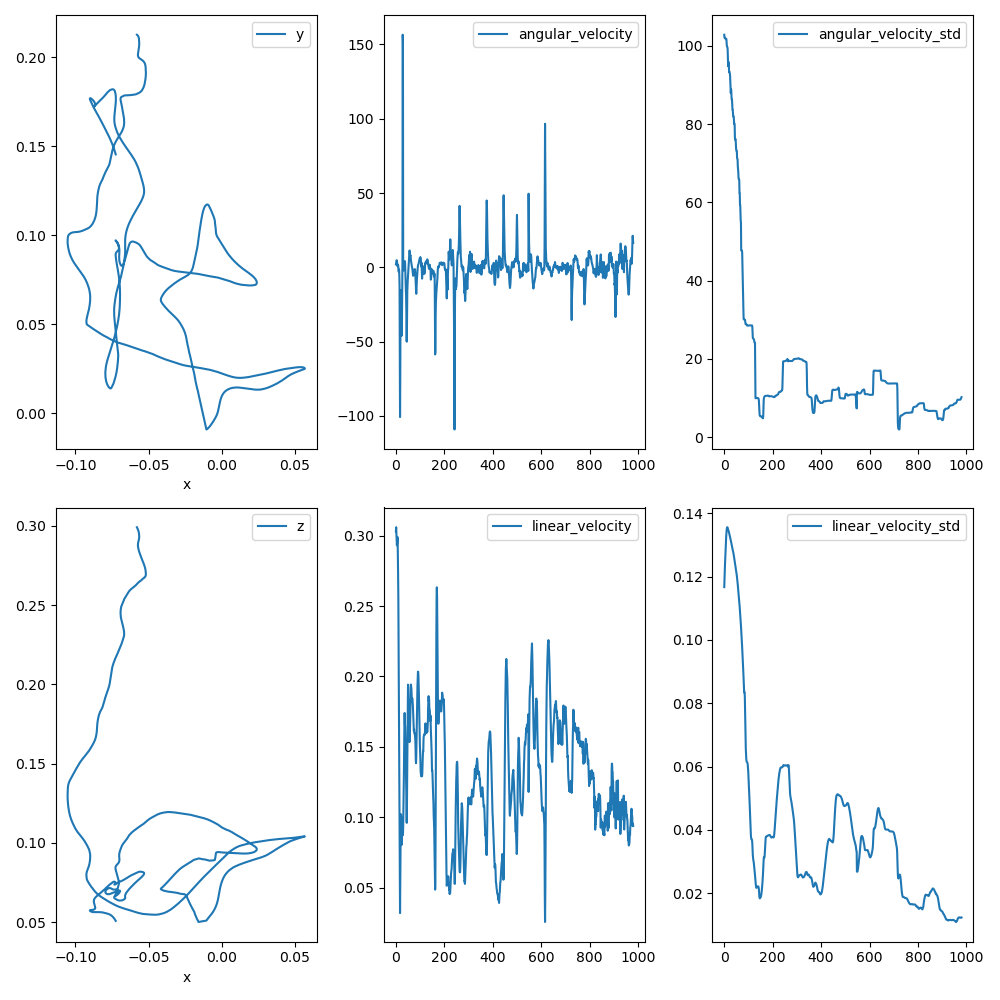

In [10]:
obj_id = result.obj_id.unique()[10]
grp = result[(result.obj_id == obj_id)].reset_index()

%matplotlib widget
plt.close("all")
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(10, 10))

grp.plot(x="x", y="y", ax=axs[0, 0])
grp.plot(x="x", y="z", ax=axs[1,0])

grp.plot(y="angular_velocity", ax=axs[0, 1])
grp.plot(y="linear_velocity", ax=axs[1, 1])

grp.plot(y="angular_velocity_std", ax=axs[0, 2])
grp.plot(y="linear_velocity_std", ax=axs[1, 2])

plt.tight_layout()
plt.show()


In [5]:
import numpy as np
import pandas as pd


def filter_flying_trajectories(
    df, min_z_height=0.05, wall_threshold=0.01, min_flight_frames=300
):
    """
    Filter the DataFrame to identify obj_ids of flies that are flying,
    based on z position and distance from the wall.

    Parameters:
    - df: pandas DataFrame with columns frame, obj_id, x, y, z
    - min_z_height: minimum height (in meters) to consider as flying (default: 0.05 m)
    - wall_threshold: distance (in meters) from arena bounds to consider as wall interaction (default: 0.01 m)
    - min_flight_frames: minimum number of consecutive frames to consider as valid flight (default: 15)

    Returns:
    - list of obj_ids corresponding to flying trajectories
    - list of DataFrames, each containing a single flight bout
    """

    # Calculate distance from arena center (in xy-plane)
    df["distance_from_center"] = np.sqrt(df["x"] ** 2 + df["y"] ** 2)

    # Create a boolean mask for flying condition
    is_flying = (df["z"].between(0.05, 0.35)) & (
        df["distance_from_center"] <= (0.25 - wall_threshold)
    )

    # Create flight groups
    flight_group = (is_flying != is_flying.shift()).cumsum()

    # Count frames in each flight group
    group_sizes = df.groupby(["obj_id", flight_group]).size()

    # Create a mask for valid flight bouts
    valid_groups = group_sizes[group_sizes >= min_flight_frames]

    # Filter the DataFrame for valid flight bouts
    flying_df = df[
        df.set_index(["obj_id", flight_group]).index.isin(valid_groups.index)
    ]

    # Get unique obj_ids of flying trajectories
    flying_obj_ids = flying_df["obj_id"].unique().tolist()

    # Create list of DataFrames for each flight bout
    flight_bouts = [group for _, group in flying_df.groupby(["obj_id", flight_group])]

    return flying_obj_ids, flight_bouts

In [6]:
flying_obj_ids, flight_bouts = filter_flying_trajectories(df)

In [24]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ipywidgets import interact, widgets
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline

In [27]:
# Create a custom colormap
colors = ["#0000FF", "#00FFFF", "#00FF00", "#FFFF00", "#FF0000"]
n_bins = 100
cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_bins)


def plot_trajectory(obj_id):
    df_obj = df[df["obj_id"] == obj_id]

    df_obj
    # Normalize timestamps for coloring
    timestamp_norm = (df_obj["timestamp"] - df_obj["timestamp"].min()) / (
        df_obj["timestamp"].max() - df_obj["timestamp"].min()
    )

    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    axs = axs.flatten()

    # XY plot
    points = axs[0].scatter(df_obj["x"], df_obj["y"], c=timestamp_norm, cmap=cmap, s=10)
    axs[0].set_xlim((-0.25, 0.25))
    axs[0].set_ylim((-0.25, 0.25))
    axs[0].set_xlabel("X")
    axs[0].set_ylabel("Y")
    axs[0].set_title(f"XY Trajectory for obj_id: {obj_id}")
    axs[0].grid(True)

    # XZ plot
    axs[1].scatter(df_obj["x"], df_obj["z"], c=timestamp_norm, cmap=cmap, s=10)
    axs[1].set_xlim((-0.25, 0.25))
    axs[1].set_ylim((0, 0.35))
    axs[1].set_xlabel("X")
    axs[1].set_ylabel("Z")
    axs[1].set_title(f"XZ Trajectory for obj_id: {obj_id}")
    axs[1].grid(True)

    # Linear velocity plot
    linear_velocity = np.sqrt(df_obj["xvel"] ** 2 + df_obj["yvel"] ** 2)
    points = axs[2].scatter(
        df_obj["timestamp"], linear_velocity, c=timestamp_norm, cmap=cmap, s=10
    )
    axs[2].set_title(f"Linear Velocity for obj_id: {obj_id}")
    axs[2].set_xlabel("Time (s)")
    axs[2].set_ylabel("Linear Velocity (m/s)")
    axs[2].grid(True)

    # Angular velocity plot
    theta = np.arctan2(df_obj["yvel"], df_obj["xvel"])
    theta_unwrap = np.unwrap(theta)
    theta_diff = np.gradient(theta_unwrap, df_obj["timestamp"])
    points = axs[3].scatter(
        df_obj["timestamp"], theta_diff, c=timestamp_norm, cmap=cmap, s=10
    )
    axs[3].set_title(f"Angular Velocity for obj_id: {obj_id}")
    axs[3].set_xlabel("Time (s)")
    axs[3].set_ylabel("Angular Velocity (rad/s)")
    axs[3].grid(True)

    # Add colorbar
    cbar = fig.colorbar(
        points, ax=axs.ravel().tolist(), orientation="vertical", pad=0.02
    )
    cbar.set_label("Normalized Time", rotation=270, labelpad=15)

    # plt.tight_layout()
    plt.show()


# Create the interactive widget
interact(
    plot_trajectory,
    obj_id=widgets.Dropdown(
        options=obj_ids,
        description="Object ID:",
        style={"description_width": "initial"},
    ),
)

interactive(children=(Dropdown(description='Object ID:', options=(np.int64(122892), np.int64(122904), np.int64…

<function __main__.plot_trajectory(obj_id)>

In [ ]:
len(obj_ids)

In [ ]:
recording_time = (df["timestamp"].iloc[-1] - df["timestamp"].iloc[0]) / 60 / 60
print(f"Total recording time: {recording_time:.2f} hours")

In [ ]:
hourly_summary = analyze_fly_activity(df)

In [ ]:
plot_activity(hourly_summary)

In [ ]:
print(hourly_summary.describe())

In [ ]:
plt.close("all")
heatmap = create_saccade_heatmap(df)
plot_saccade_heatmap(heatmap, sigma=1)